In [3]:
# 1. 라이브러리 설치
!pip install pandas statsmodels matplotlib

In [4]:
# 2. 라이브러리 불러오기
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [7]:
# 3. 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving combined_sense_applicability_data.csv to combined_sense_applicability_data.csv


In [8]:
df = pd.read_csv("combined_sense_applicability_data.csv")  # 업로드된 파일명 확인 후 수정

In [9]:
# 4. 전처리: 인간 데이터만 필터링, dissimilar 제외
df = df[df['model_type'].str.lower() == 'human']
df = df[df['sense_type'].isin(['correct', 'similar'])]

In [10]:
# 5. 기준 범주 설정
df['sense_type'] = pd.Categorical(df['sense_type'], categories=['similar', 'correct'])
df['relation_type'] = pd.Categorical(df['relation_type'], categories=[
    'contextual implication', 'context-dependent polysemy', 'causal_overlap',
    'subcategories', 'extension', 'extension_overlap'
])

In [25]:
# 6. 혼합효과 회귀 모델 (교호작용 포함: sense_type × relation_type): OLS로 전환
ols_model = smf.ols(
    'applicability_score ~ C(sense_type, Treatment(reference="similar")) * '
    'C(relation_type, Treatment(reference="contextual implication"))',
    data=df
).fit()
print(ols_model.summary())

                             OLS Regression Results                            
Dep. Variable:     applicability_score   R-squared:                       0.385
Model:                             OLS   Adj. R-squared:                  0.383
Method:                  Least Squares   F-statistic:                     231.7
Date:                 Sat, 30 Aug 2025   Prob (F-statistic):               0.00
Time:                         08:28:35   Log-Likelihood:                -6045.9
No. Observations:                 4080   AIC:                         1.212e+04
Df Residuals:                     4068   BIC:                         1.219e+04
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                                                                                                                                             coef    std err          t      P>|t|      

In [26]:
# 7. 95% CI 계산
conf_int = ols_model.conf_int()
conf_int.columns = ['2.5%', '97.5%']
conf_int['Estimate'] = ols_model.params
print("\n### 95% Confidence Intervals for Fixed Effects ###")
print(conf_int)


### 95% Confidence Intervals for Fixed Effects ###
                                                        2.5%     97.5%  \
Intercept                                           1.744154  2.055846   
C(sense_type, Treatment(reference="similar"))[T...  2.318490  2.759288   
C(relation_type, Treatment(reference="contextua...  0.062934  0.503732   
C(relation_type, Treatment(reference="contextua...  1.736304  2.087939   
C(relation_type, Treatment(reference="contextua...  1.633921  1.999412   
C(relation_type, Treatment(reference="contextua...  0.561348  0.933890   
C(relation_type, Treatment(reference="contextua...  1.186920  1.679747   
C(sense_type, Treatment(reference="similar"))[T... -0.406136  0.217247   
C(sense_type, Treatment(reference="similar"))[T... -2.040563 -1.543275   
C(sense_type, Treatment(reference="similar"))[T... -1.907746 -1.390865   
C(sense_type, Treatment(reference="similar"))[T... -0.911840 -0.384985   
C(sense_type, Treatment(reference="similar"))[T... -1.479037

In [28]:
# 8. 유의한 효과 필터링
sig_effects = conf_int.loc[ols_model.pvalues < 0.05]
print("\n### Significant Fixed Effects with 95% CI ###")
print(sig_effects)


### Significant Fixed Effects with 95% CI ###
                                                        2.5%     97.5%  \
Intercept                                           1.744154  2.055846   
C(sense_type, Treatment(reference="similar"))[T...  2.318490  2.759288   
C(relation_type, Treatment(reference="contextua...  0.062934  0.503732   
C(relation_type, Treatment(reference="contextua...  1.736304  2.087939   
C(relation_type, Treatment(reference="contextua...  1.633921  1.999412   
C(relation_type, Treatment(reference="contextua...  0.561348  0.933890   
C(relation_type, Treatment(reference="contextua...  1.186920  1.679747   
C(sense_type, Treatment(reference="similar"))[T... -2.040563 -1.543275   
C(sense_type, Treatment(reference="similar"))[T... -1.907746 -1.390865   
C(sense_type, Treatment(reference="similar"))[T... -0.911840 -0.384985   
C(sense_type, Treatment(reference="similar"))[T... -1.479037 -0.782074   

                                                    Estimate  
I

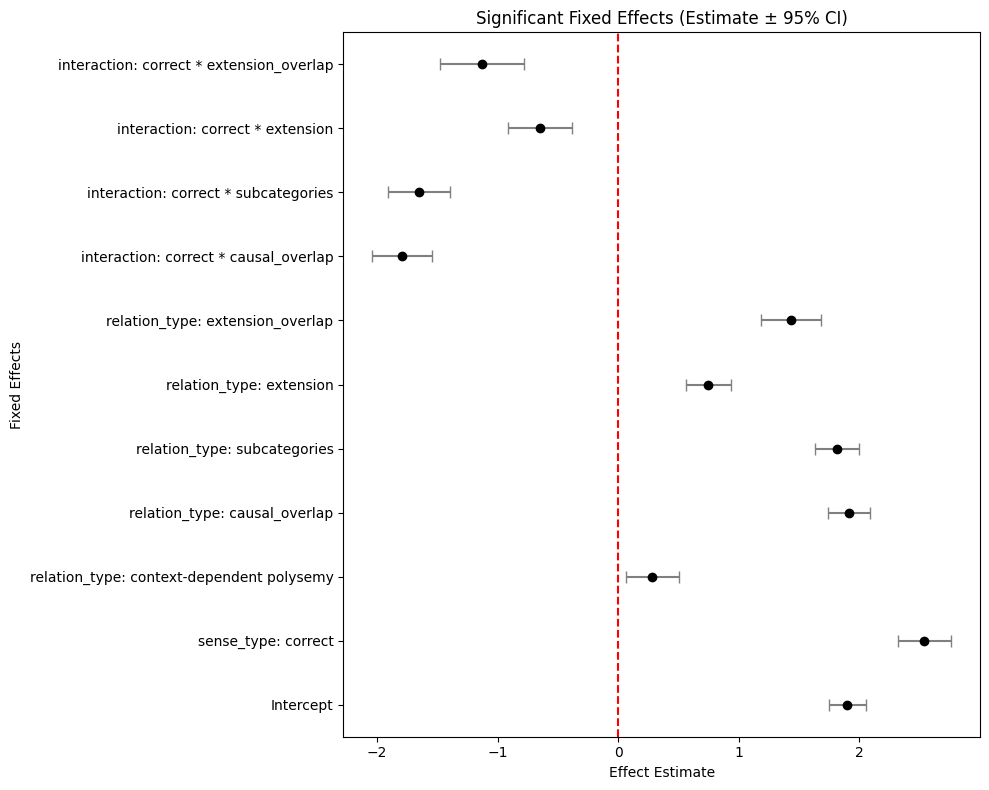

In [30]:
# 9. 시각화: 고정효과 계수 및 95% CI 플롯
# sig_effects 변수가 이전 셀에서 정의되었는지 확인
if 'sig_effects' not in locals():
    print("Error: 'sig_effects' is not defined. Please ensure the previous cell (cell id M-KNr9tEktNx) has been executed successfully.")
else:
    sig_effects_no_verb = sig_effects[~sig_effects.index.str.contains('verb')]

    # 간결한 레이블 매핑 생성 (필요에 따라 수정)
    label_mapping = {
        'Intercept': 'Intercept',
        'C(sense_type, Treatment(reference="similar"))[T.correct]': 'sense_type: correct',
        'C(relation_type, Treatment(reference="contextual implication"))[T.context-dependent polysemy]': 'relation_type: context-dependent polysemy',
        'C(relation_type, Treatment(reference="contextual implication"))[T.causal_overlap]': 'relation_type: causal_overlap',
        'C(relation_type, Treatment(reference="contextual implication"))[T.subcategories]': 'relation_type: subcategories',
        'C(relation_type, Treatment(reference="contextual implication"))[T.extension]': 'relation_type: extension',
        'C(relation_type, Treatment(reference="contextual implication"))[T.extension_overlap]': 'relation_type: extension_overlap',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.context-dependent polysemy]': 'interaction: correct * context-dependent polysemy',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.causal_overlap]': 'interaction: correct * causal_overlap',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.subcategories]': 'interaction: correct * subcategories',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.extension]': 'interaction: correct * extension',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.extension_overlap]': 'interaction: correct * extension_overlap',
        'Group Var': 'Group Variance', # Added Group Var
        'sentence_id Var': 'Sentence ID Variance' # Added Sentence ID Var
    }

    # 필터링된 데이터프레임의 인덱스에 매핑 적용
    # 매핑되지 않은 레이블은 원래 레이블을 유지하도록 수정
    sig_effects_no_verb_labeled = sig_effects_no_verb.copy()
    sig_effects_no_verb_labeled.index = sig_effects_no_verb_labeled.index.map(lambda x: label_mapping.get(x, x))


    plt.figure(figsize=(10, 8)) # Adjusted figure size for better readability
    plt.errorbar(sig_effects_no_verb_labeled['Estimate'], sig_effects_no_verb_labeled.index,
                 xerr=[sig_effects_no_verb_labeled['Estimate'] - sig_effects_no_verb_labeled['2.5%'],
                       sig_effects_no_verb_labeled['97.5%'] - sig_effects_no_verb_labeled['Estimate']],
                 fmt='o', color='black', ecolor='gray', capsize=4)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title("Significant Fixed Effects (Estimate ± 95% CI)")
    plt.xlabel("Effect Estimate")
    plt.ylabel("Fixed Effects")
    plt.tight_layout()
    plt.show()

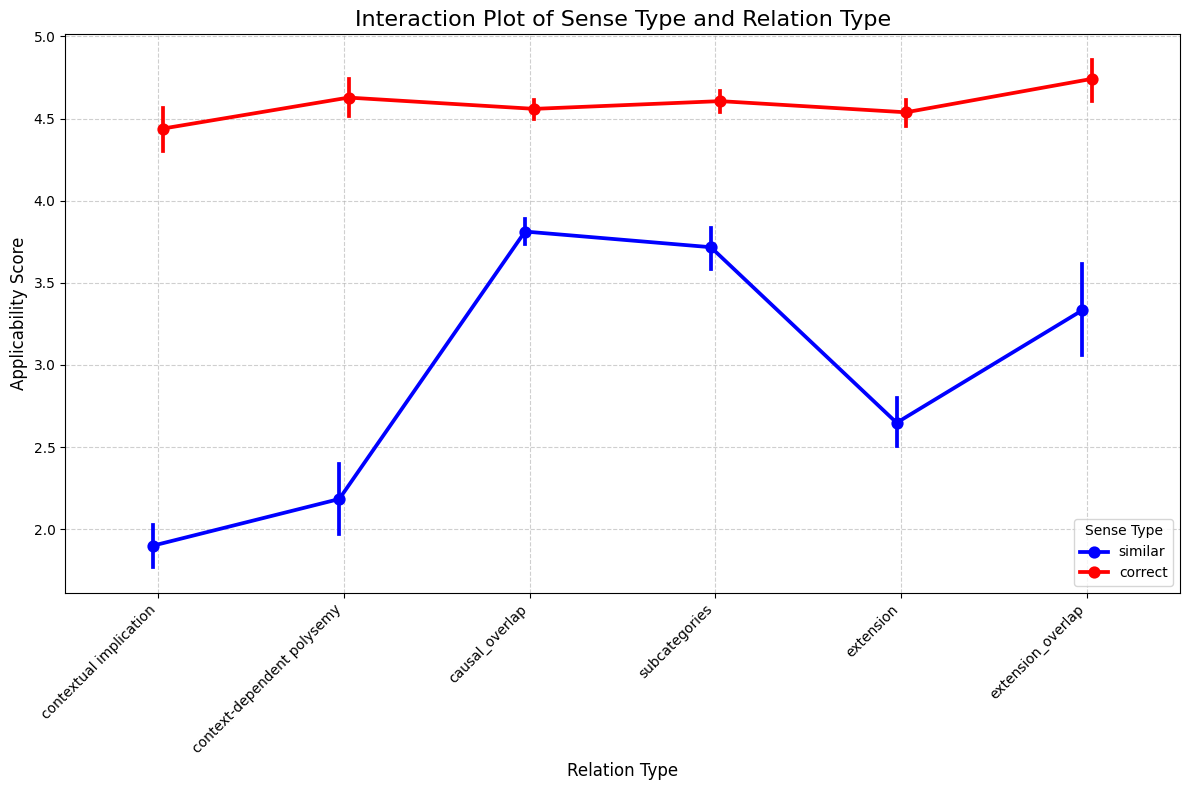

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.pointplot(x='relation_type', y='applicability_score', hue='sense_type', data=df, dodge=True,
              palette={'similar': 'blue', 'correct': 'red'})
plt.title('Interaction Plot of Sense Type and Relation Type', fontsize=16)
plt.xlabel('Relation Type', fontsize=12)
plt.ylabel('Applicability Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sense Type')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

`sig_effects` 변수를 사용하기 전에 이전 셀(`M-KNr9tEktNx`)이 성공적으로 실행되었는지 확인하세요. 이전 셀이 실행되지 않았다면 해당 셀을 실행한 후 아래 코드를 실행하여 유의한 고정효과를 시각화할 수 있습니다.

In [21]:
# 9. 시각화: 고정효과 계수 및 95% CI 플롯
# sig_effects 변수가 이전 셀에서 정의되었는지 확인
if 'sig_effects' not in locals():
    print("Error: 'sig_effects' is not defined. Please ensure the previous cell (cell id M-KNr9tEktNx) has been executed successfully.")
else:
    sig_effects_no_verb = sig_effects[~sig_effects.index.str.contains('verb')]

    # 간결한 레이블 매핑 생성 (필요에 따라 수정)
    label_mapping = {
        'Intercept': 'Intercept',
        'C(sense_type, Treatment(reference="similar"))[T.correct]': 'sense_type: correct',
        'C(relation_type, Treatment(reference="contextual implication"))[T.context-dependent polysemy]': 'relation_type: context-dependent polysemy',
        'C(relation_type, Treatment(reference="contextual implication"))[T.causal_overlap]': 'relation_type: causal_overlap',
        'C(relation_type, Treatment(reference="contextual implication"))[T.subcategories]': 'relation_type: subcategories',
        'C(relation_type, Treatment(reference="contextual implication"))[T.extension]': 'relation_type: extension',
        'C(relation_type, Treatment(reference="contextual implication"))[T.extension_overlap]': 'relation_type: extension_overlap',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.context-dependent polysemy]': 'interaction: correct * context-dependent polysemy',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.causal_overlap]': 'interaction: correct * causal_overlap',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.subcategories]': 'interaction: correct * subcategories',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.extension]': 'interaction: correct * extension',
        'C(sense_type, Treatment(reference="similar"))[T.correct]:C(relation_type, Treatment(reference="contextual implication"))[T.extension_overlap]': 'interaction: correct * extension_overlap',
        'Group Var': 'Group Variance', # Added Group Var
        'sentence_id Var': 'Sentence ID Variance' # Added Sentence ID Var
    }

    # 필터링된 데이터프레임의 인덱스에 매핑 적용
    sig_effects_no_verb_labeled = sig_effects_no_verb.copy()
    sig_effects_no_verb_labeled.index = sig_effects_no_verb_labeled.index.map(label_mapping).fillna(sig_effects_no_verb_labeled.index)


    plt.figure(figsize=(10, 8)) # Adjusted figure size for better readability
    plt.errorbar(sig_effects_no_verb_labeled['Estimate'], sig_effects_no_verb_labeled.index,
                 xerr=[sig_effects_no_verb_labeled['Estimate'] - sig_effects_no_verb_labeled['2.5%'],
                       sig_effects_no_verb_labeled['97.5%'] - sig_effects_no_verb_labeled['Estimate']],
                 fmt='o', color='black', ecolor='gray', capsize=4)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title("Significant Fixed Effects (Estimate ± 95% CI)")
    plt.xlabel("Effect Estimate")
    plt.ylabel("Fixed Effects")
    plt.tight_layout()
    plt.show()

Error: 'sig_effects' is not defined. Please ensure the previous cell (cell id M-KNr9tEktNx) has been executed successfully.


`ols_model` 변수를 사용하기 전에 이전 셀(`ELm1x2t7c_kF`)이 성공적으로 실행되었는지 확인하세요. 이전 셀이 실행되지 않았다면 해당 셀을 실행한 후 아래 코드를 실행하여 95% 신뢰 구간을 계산할 수 있습니다.

In [22]:
# 7. 95% CI 계산
# ols_model 변수가 이전 셀에서 정의되었는지 확인
if 'ols_model' not in locals():
    print("Error: 'ols_model' is not defined. Please ensure the previous cell (cell id ELm1x2t7c_kF) has been executed successfully.")
else:
    conf_int = ols_model.conf_int()
    conf_int.columns = ['2.5%', '97.5%']
    conf_int['Estimate'] = ols_model.params
    print("\n### 95% Confidence Intervals for Fixed Effects ###")
    print(conf_int)

Error: 'ols_model' is not defined. Please ensure the previous cell (cell id ELm1x2t7c_kF) has been executed successfully.
